# Importation des libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, re
from connexion_db import *
from wordcloud import WordCloud

# Récupération des commentaires de tous les restaurants

In [2]:
# récupération de toutes les reviews en brut
data = get_all_reviews("raw")

df = pd.DataFrame(data)

print(df)

      note                                              texte
0      1.0  Ce restaurant est une honte pour l'image de la...
1      1.0  On as pris 1 Tartar de boeuf + frite et Omelet...
2      2.0  Tarif tres élevé pour une qualité qui laisse à...
3      1.0  J’aurais du davantage regarde les avis sur int...
4      1.0  Fuyez !\nService détestable par épisode et pou...
...    ...                                                ...
3473   3.0  Mon ami et moi avons adoré ce quartier de Pari...
3474   2.0  Nous avons mangé ici le week-end dernier. L'en...
3475   4.0  Nous étions un grand groupe (9) pour les famil...
3476   1.0  Cet endroit était horrible. Les serveurs étaie...
3477   1.0  Nous se promenaient devant l'après-midi le pre...

[3478 rows x 2 columns]


# Fonction utile

In [3]:
def remove_emojis(input_text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', input_text)

def supprimer_espaces_inutiles(chaine):
    # Utiliser une expression régulière pour remplacer les espaces multiples par un seul espace
    chaine_sans_espaces_inutiles = re.sub(r'\s+', ' ', chaine)
    return chaine_sans_espaces_inutiles.strip()  # Supprimer les espaces au début et à la fin de la chaîne

# Créer une fonction pour nettoyer le texte
def clean_text(text):
    # retirer les nombres
    text = re.sub(r'\d+', '', text)
    # Supprimer les emojis
    text = remove_emojis(text)
    return text

# Vérification si les données sont vides

In [4]:
# check valeur NA, null, NaN
print(df.isna().sum())

note     0
texte    0
dtype: int64


# Nétoyage des données commentaires

In [5]:
df['texte'] = df['texte'].apply(clean_text)
df['note'] = pd.to_numeric(df['note'], errors='coerce')

conditions = [
        (df['note'].isin([1, 2])),  # Conditions pour les notes 1 et 2
        (df['note'] == 3),           # Condition pour la note 3
        (df['note'].isin([4, 5]))    # Conditions pour les notes 4 et 5
    ]

# Valeurs à attribuer si les conditions sont respectées, 0 pour négatif, 1 pour neutre et 2 pour positif
values = [0, 1, 2]

df['label'] = np.select(conditions, values)  # Création de la nouvelle colonne
df['label'] = df['label'].astype(int)  # Conversion de la colonne en entier

print(df['label'].value_counts())

label
0    1644
2    1250
1     584
Name: count, dtype: int64


# Insertion des données dans la collection test

In [6]:
# Envoie mes données nettoyées en base de données
data_test = df.to_dict(orient='records')
add_all_reviews(data_test, 'test')
print(df['label'].value_counts())

label
0    1644
2    1250
1     584
Name: count, dtype: int64


# Insertion des données dans la collection train

In [7]:
# Create a new CSV with equal number of positive, negative and neutral reviews
df_negative = df[df['label'] == 0].sample(1000) # 1000 negative reviews
df_positive = df[df['label'] == 2].sample(1000) # 1000 positive reviews

df_train = pd.concat([df_negative, df_positive], axis=0).reset_index(drop=True)

# insertion dans la base de données des reviews filtrées
data_train = df_train.to_dict(orient='records')
add_all_reviews(data_train, 'train')

print(df_train['label'].value_counts())

label
0    1000
2    1000
Name: count, dtype: int64


# Apperçu des données

In [8]:
nlp_data = pd.DataFrame({'texte': df_train['texte'], 'label': df_train['label']})

nlp_data

,texte,label
0,"L’accueil était très souriant, les serveurs/se...",0
1,Nous étions et avons pris un croque monsieur ...,0
2,Pour un retour en terrasse j’ai voulu prendre ...,0
3,A fuir !\nTu commande un orangina mais tu n as...,0
4,"Nous y sommes allés à personnes, vendredi /. ...",0
...,...,...
1995,"Ce café est incroyable. Le personnel, le cadre...",2
1996,Excellente expérience renouvelée dans les étab...,2
1997,Un grand espace où l'on peut avoir une place r...,2
1998,Il a tout ce qu'il faut et un super restaurant...,2


# Vérification s'il y a des données nulles

In [9]:
print("Check for missing values in Train dataset")
null_check=nlp_data.isnull().sum()
print(null_check)

Check for missing values in Train dataset
texte    0
label    0
dtype: int64


# Apperçu des mots qui seront supprimés avec stop word

In [10]:
nlp = spacy.load('fr_core_news_sm')
nlp.Defaults.stop_words

{'a',
 'abord',
 'afin',
 'ah',
 'ai',
 'aie',
 'ainsi',
 'ait',
 'allaient',
 'allons',
 'alors',
 'anterieur',
 'anterieure',
 'anterieures',
 'antérieur',
 'antérieure',
 'antérieures',
 'apres',
 'après',
 'as',
 'assez',
 'attendu',
 'au',
 'aupres',
 'auquel',
 'aura',
 'auraient',
 'aurait',
 'auront',
 'aussi',
 'autre',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avoir',
 'avons',
 'ayant',
 'bas',
 'basee',
 'bat',
 "c'",
 'car',
 'ce',
 'ceci',
 'cela',
 'celle',
 'celle-ci',
 'celle-la',
 'celle-là',
 'celles',
 'celles-ci',
 'celles-la',
 'celles-là',
 'celui',
 'celui-ci',
 'celui-la',
 'celui-là',
 'cent',
 'cependant',
 'certain',
 'certaine',
 'certaines',
 'certains',
 'certes',
 'ces',
 'cet',
 'cette',
 'ceux',
 'ceux-ci',
 'ceux-là',
 'chacun',
 'chacune',
 'chaque',
 'chez',
 'ci',
 'cinq',
 'cinquantaine',
 'cinquante',
 'cinquantième',
 'cinquième',
 'combien',
 'comme',
 'comment',

# Application de la fonction de nétoyage

In [88]:
#fonction qui prend en argument une review et qui en effectue le prétraitement nécessaire
#C'est à dire ne garder que les mots sauf les stopwords
def treat_comment(comment):
    spacy_comment = nlp(comment, disable=["parser", "ner", "textcat"])
    treated_tokens = [w.text for w in spacy_comment if w.is_alpha and not w.is_stop]
    # retirer les lettres seules
    treated_tokens = [w for w in treated_tokens if len(w)>1]
    # retirer les nombres seuls
    treated_tokens = [w for w in treated_tokens if not w.isnumeric()]
    # retirer les mots inutiles
    treated_tokens = [w for w in treated_tokens if w not in nlp.Defaults.stop_words]
    # retire les mots de moins de 3 lettres
    treated_tokens = [w for w in treated_tokens if len(w)>2]
    return " ".join(treated_tokens)
clean_data = nlp_data.copy()
clean_data['texte'] = clean_data['texte'].apply(treat_comment)

# Vérification du nombre de données après la transformation

In [52]:
clean_data.groupby('label').count()

,texte
label,
0,1000
2,1000


# Visualitation du nombre de données après la transformation

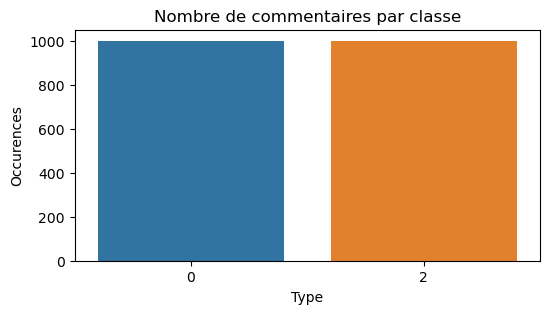

In [54]:
x = clean_data.groupby('label').count().reset_index()
#plot
plt.figure(figsize=(6,3))
ax= sns.barplot(x, x="label", y="texte")
plt.title("Nombre de commentaires par classe")
plt.xlabel('Type')
plt.ylabel('Occurences')

plt.show()

# Visualitation des mots les plus présents dans les commentaires négatifs

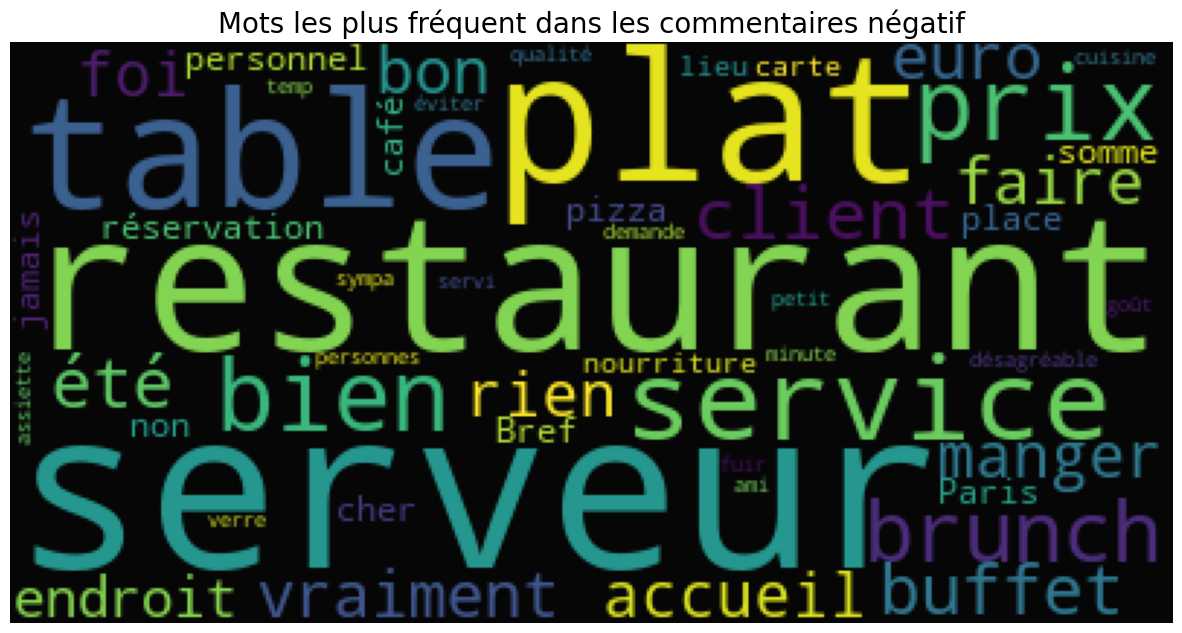

In [55]:
subset=clean_data[clean_data['label']==0]
text=subset.texte.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires négatif", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# Visualitation des mots les plus présents dans les commentaires possitifs

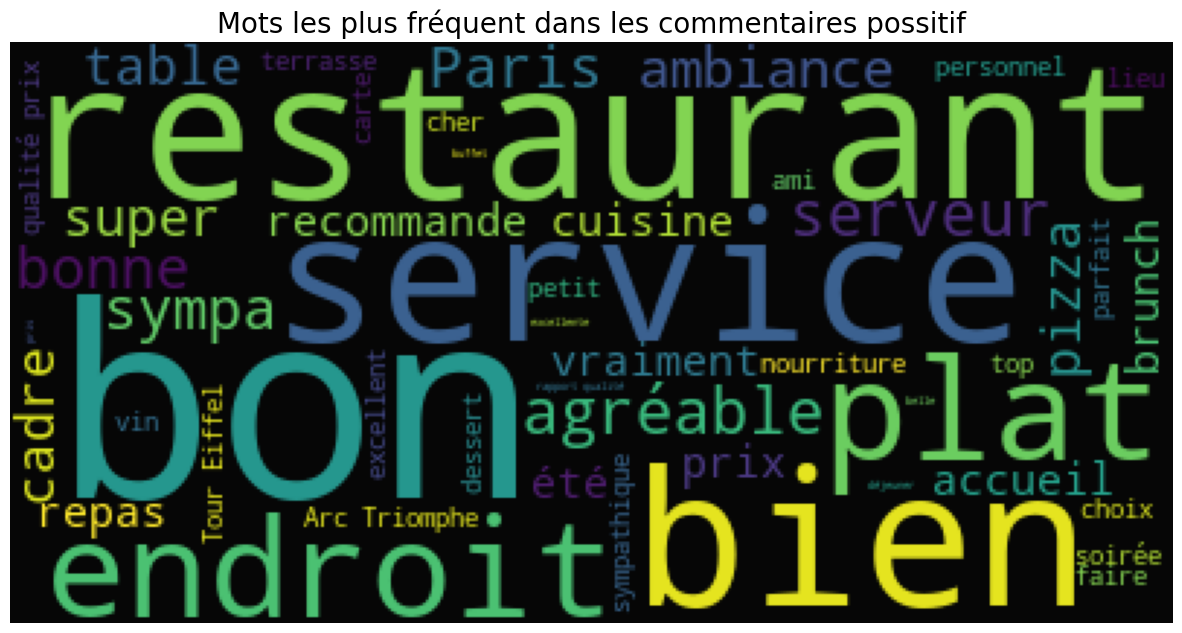

In [87]:
subset=clean_data[clean_data['label']==2]
text=subset.texte.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires possitif", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# Vertorisation des commentaires, permet de traduire pour l'apprentissage du modèle 

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(clean_data['texte'])

In [74]:
X.shape

(2000, 2000)

In [75]:
print(X[2])

  (0, 1896)	0.17522354463766263
  (0, 221)	0.20890798223463888
  (0, 1497)	0.1605429856356587
  (0, 340)	0.2961997744956736
  (0, 630)	0.22443748712871148
  (0, 57)	0.5752523285095413
  (0, 374)	0.5371186062626034
  (0, 227)	0.11889518009868993
  (0, 1380)	0.18839409415224048
  (0, 1950)	0.25503114987357045
  (0, 1799)	0.16641122999787425


# Afficher les mots les plus fréquents

In [76]:
for i in vectorizer.get_feature_names_out():
    print(i)

abordable
abordables
absence
absolument
acceptable
accepte
acceuil
accompagne
accompagnement
accompagnements
accompagner
accompagné
accompagnée
accord
accueil
accueillant
accueillante
accueillants
accueille
accueilli
accueillir
accueillis
accès
accéder
acheter
acide
addition
admirer
adorable
adore
adoré
adresse
adresses
adultes
advisor
affaire
affaires
affamés
affichés
affluence
after
agents
agit
agneau
agreable
agressif
agréable
agréablement
agréables
ailleurs
aimable
aimables
aime
aimez
aimé
air
aise
alcool
alentours
alexandre
alimentaire
aliments
allait
aller
allez
allé
allée
allées
allés
amabilité
amateurs
ambiance
ami
amical
amie
amies
amis
amoureux
amusant
amuser
amène
and
anglais
animé
anniversaire
annonce
annoncé
annuler
année
années
ans
antipasti
août
appareil
apparemment
appeler
appelle
appelé
apporte
apporter
apporté
appris
approche
appréciable
apprécier
apprécié
apéritif
apéro
arc
archi
argent
arnaque
arnaquer
arrivant
arrive
arrivent
arriver
arrivons
arrivé
arrivée
arrivée

# indice des vocabulaires

In [77]:
vectorizer.vocabulary_

{'accueil': 14,
 'souriant': 1726,
 'serveurs': 1671,
 'gentil': 837,
 'gros': 869,
 'point': 1346,
 'positif': 1362,
 'buffet': 263,
 'trouvé': 1862,
 'rapport': 1489,
 'qualité': 1466,
 'prix': 1401,
 'mauvais': 1093,
 'produits': 1409,
 'café': 274,
 'jus': 1017,
 'bouteilles': 246,
 'charcuterie': 325,
 'viennoiseries': 1916,
 'œufs': 1999,
 'bacon': 176,
 'quiches': 1477,
 'froids': 808,
 'ensemble': 658,
 'choses': 355,
 'expérience': 714,
 'vraiment': 1955,
 'mauvaise': 1094,
 'aucune': 159,
 'volonté': 1944,
 'établissement': 1981,
 'reçu': 1570,
 'mail': 1063,
 'demandant': 520,
 'avis': 173,
 'reviendrons': 1567,
 'bonne': 233,
 'étions': 1984,
 'pris': 1398,
 'croque': 487,
 'monsieur': 1147,
 'salades': 1620,
 'basique': 188,
 'personnel': 1300,
 'sympathique': 1767,
 'nourriture': 1190,
 'terrible': 1801,
 'cher': 339,
 'terrasse': 1799,
 'voulu': 1950,
 'prendre': 1380,
 'bon': 227,
 'cocktail': 374,
 'alcool': 57,
 'déçu': 630,
 'cherche': 340,
 'recommande': 1497,
 'boi

In [78]:
from sklearn.model_selection import train_test_split

Y = clean_data.label.values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [79]:
from sklearn.linear_model import LogisticRegression

In [80]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

# Score du modèle

In [89]:
# Score du modèle sur les données d'entraînement
model.score(X_train, Y_train)

0.974

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [83]:
y_pred = model.predict(X_test)

In [84]:
accuracy_score(Y_test, y_pred)

0.92

In [85]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       257
           2       0.90      0.94      0.92       243

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [90]:
confusion_matrix(Y_test, y_pred)
# TN, FP
# FN, TP

array([[231,  26],
       [ 14, 229]], dtype=int64)